## Basic Setup

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import extract_latent_representations, apply_tsne, plot_latent_space
from utils.evaluation import evaluate_autoencoder

# import importlib
# importlib.reload(set_seed)

In [2]:
# Hyperparameter to tune
config = {
    "comment" : "full test back2mae",
    "epochs" : 200,
    "loss" : "mae",
    "optimizer" : "adam",
    "dropout" : 0.3,
    "batch_size" : 32,
    "bottle_neck_dim" : 512,
    "threshold_percentage" : 95,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [3]:
wandb.init(project="autoencoder", config=config, notes=config['comment'])
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hendrik-spl (itu-aml-project). Use `wandb login --relogin` to force relogin


In [4]:
root_dir = get_root_dir()
setup_gpu()
set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

No GPU found, using CPU.


In [5]:
train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [6]:
def DSSIM_loss(y_true, y_pred):
    return 1/2 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))/2

In [7]:
def build_autoencoder(input_shape, optimizer, loss, dropout, bottleneck_dim):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(dropout)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)+
    x = Dropout(dropout)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(dropout)(x)

    # Bottleneck
    x = Flatten()(x)                        # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(bottleneck_dim)(x)      # Latent space size reduced to 512
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    # x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    # x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x) # (64, 64, 128)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    # x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    # x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # (128, 128, 64)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    # x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    # x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x) # (256, 256, 32)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)

    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    if loss == 'ssim':
        loss=DSSIM_loss
    
    autoencoder = Model(input_img, x)
    autoencoder.compile(
        optimizer=optimizer,
        loss=loss
        )
    
    return autoencoder

autoencoder = build_autoencoder(input_shape=INPUT_SHAPE, optimizer=config.optimizer, loss=config.loss, dropout=config.dropout, bottleneck_dim=config.bottle_neck_dim)

## Potential Improvements highlighted by ChatGPT

- MaxPooling and UpSampling Inconsistency:
    - The encoder progressively reduces the spatial dimensions using MaxPooling2D. However, the decoder uses UpSampling2D for reconstruction, which is a deterministic upscaling method. This may lead to “checkerboard artifacts” in the reconstructed image.
    - Consider using learned upsampling layers such as Conv2DTranspose instead of UpSampling2D.

- Loss Function Mismatch:
    - The final activation in the decoder is sigmoid, which is appropriate for normalizing pixel values in the range [0, 1]. However, the loss function should align with this.
	- If you’re using mean squared error (MSE) or mean absolute error (MAE), these may not work as well for binary-like pixel values.
	- Consider using binary_crossentropy or Kullback-Leibler divergence (if appropriate) when working with sigmoid outputs.

In [8]:
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=10,
    start_from_epoch=10
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

In [9]:
history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        # early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.2551 
Epoch 1: val_loss improved from inf to 0.45188, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/full test back2mae_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 105s 13s/step - loss: 0.2519 - val_loss: 0.4519
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.1567 
Epoch 2: val_loss improved from 0.45188 to 0.26241, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/full test back2mae_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 16s/step - loss: 0.1552 - val_loss: 0.2624
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.1054 
Epoch 3: val_loss improved from 0.26241 to 0.18963, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/full test back2mae_checkpoint.model.keras
8/8 ━━━━━━━━━━━━

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▆▆▅▆▇▆▆▆▆▄▃▂▃▂▃▃▂▁▂▂▁▃▁▂▂▃▄▃▂▁▂▁▄▅▂▁▁
epoch/epoch,199
epoch/learning_rate,0.001
epoch/loss,0.01827
epoch/val_loss,0.01962


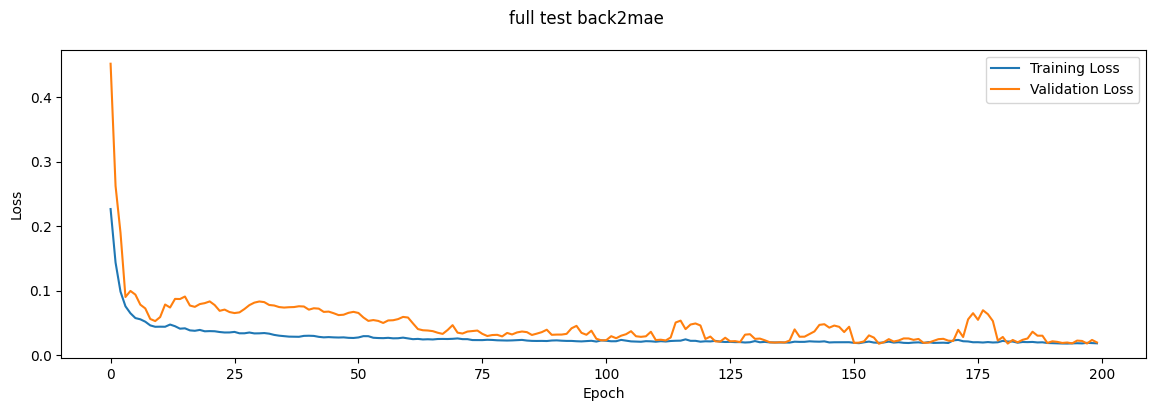

Best train_loss: 0.0179
Best val_loss: 0.0176
Last improvement of val_loss at epoch: 1


In [10]:
# plot the training history
plot_history(comment=config.comment, history=history)

In [11]:
# load the best model and save that model
autoencoder.load_weights(cpkt_path)
autoencoder.save(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


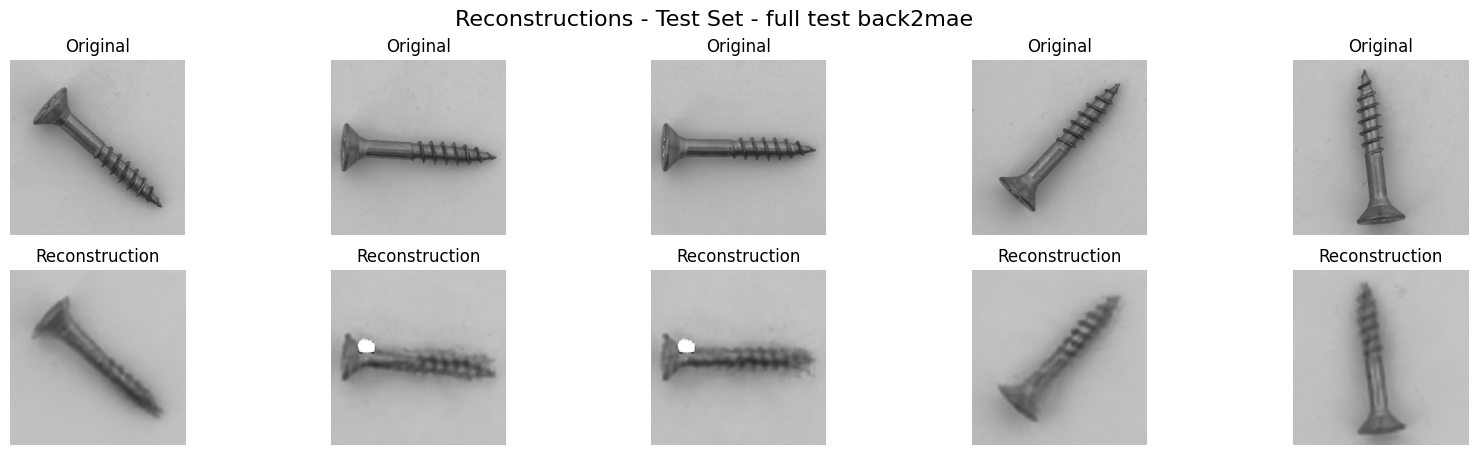

In [12]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title=f"Reconstructions - Test Set - {config.comment}")

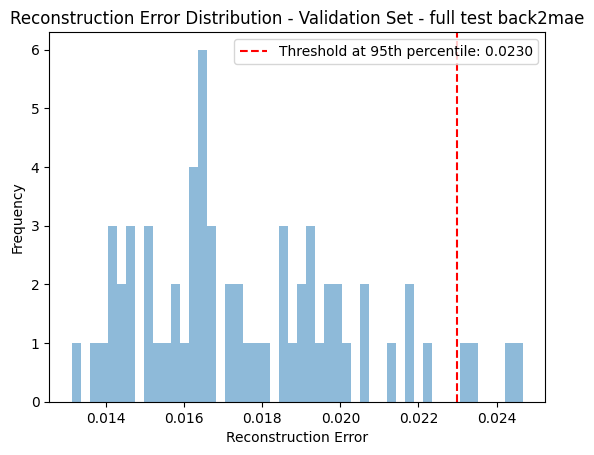

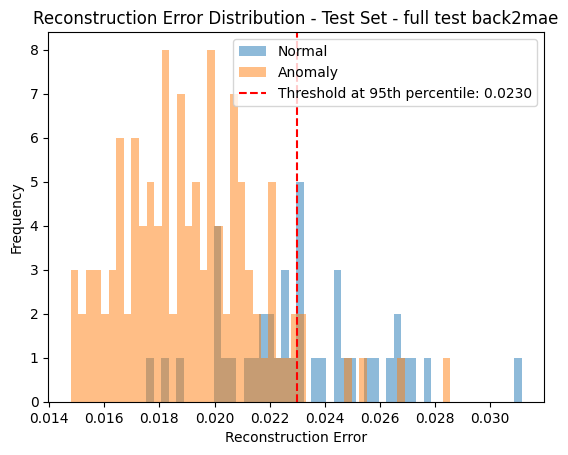

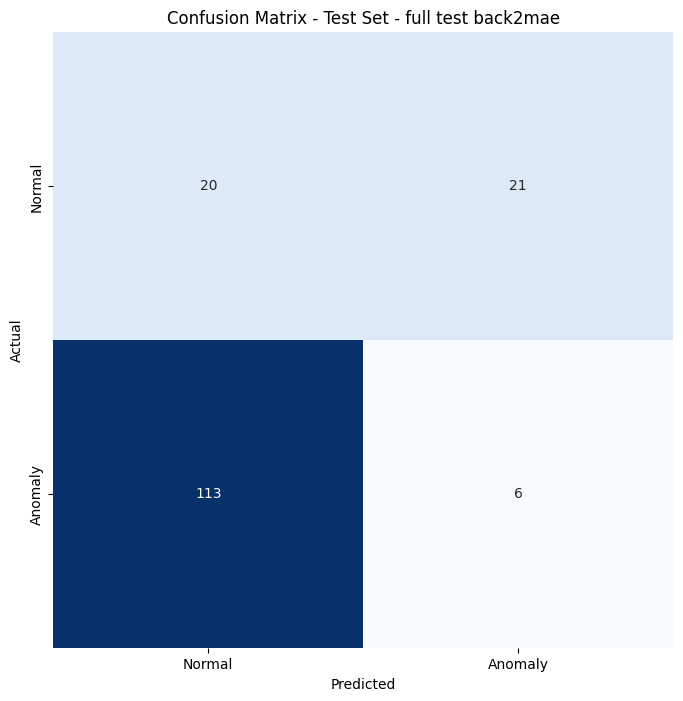

In [18]:
evaluate_autoencoder(
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator,
    config = config
    )

Python(26962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


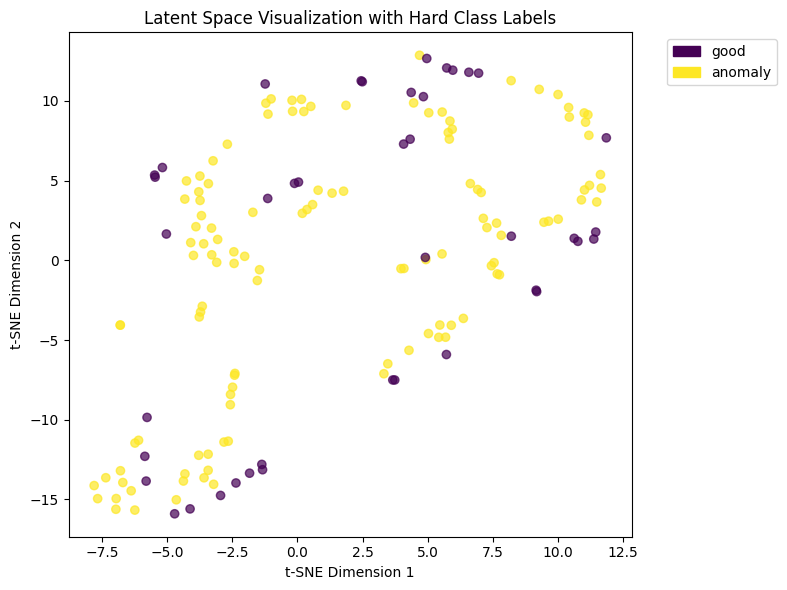

In [14]:
# Step 1: Extract latent representations
latent_representations, labels_indices = extract_latent_representations(autoencoder, test_generator)

# Step 2: Apply t-SNE
latent_2d = apply_tsne(latent_representations)

# Step 3: Plot latent space
plot_latent_space(latent_2d, labels_indices)